In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import time
import shutil
import pathlib
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [4]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [5]:
# data_dir = '/kaggle/input/v1-dataset-plant-village/Plant_leave_diseases_dataset_with_augmentation'

data_dir ='/kaggle/input/plant-disease-classification-merged-dataset'

    # Get splitted data
train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)


Found 63269 validated image filenames belonging to 88 classes.
Found 7908 validated image filenames belonging to 88 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 7909 validated image filenames belonging to 88 classes.


In [6]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
    model = Sequential([
            base_model,
            BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
            Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                        bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
            Dropout(rate= 0.45, seed= 123),
            Dense(class_count, activation= 'softmax')])

    model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

    model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 88)                22616     
                                                         

In [7]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
strategy1 = tf.distribute.MirroredStrategy()
with strategy1.scope():
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
    model1 = Sequential([
            base_model,
            BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
            Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                        bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
            Dropout(rate= 0.45, seed= 123),
            Dense(class_count, activation= 'softmax')])

    model1.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

    model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 88)                22616     
                                                                 
Total params: 11205767 (42.75 MB)
Trainable params: 11

In [8]:
checkpoint_callback = ModelCheckpoint(filepath='/kaggle/working/best_modelv2', 
                                      monitor='val_accuracy', 
                                      save_best_only=True,
                                      save_weights_only=False,
                                      mode='max',
                                      verbose=1)

In [9]:
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=10, 
                                        restore_best_weights=True,
                                        verbose=1)

In [10]:
# history = model.fit(x= train_gen,
#                     epochs= 40,
#                     verbose= 1,
#                     callbacks=[checkpoint_callback, early_stopping_callback],
#                     validation_data= valid_gen, 
#                     validation_steps= None,
#                     use_multiprocessing=True,  # Use dual CPUs
#                     workers=3 , # Number of worker processes
#                     max_queue_size=10,
#                     shuffle= False)

In [11]:
history = model.fit(x= train_gen,
                    epochs= 40,
                    verbose= 1,
                    callbacks=[checkpoint_callback, early_stopping_callback],
                    validation_data= valid_gen, 
                    validation_steps= None,
                    use_multiprocessing=True,  # Use dual CPUs
                    workers=3 , # Number of worker processes
                    max_queue_size=10,
                    shuffle= False)

Epoch 1/40


2024-04-26 14:57:47.014372: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1582/1582 [==============================] - ETA: 0s - loss: 2.8359 - accuracy: 0.8341
Epoch 1: val_accuracy improved from -inf to 0.93083, saving model to /kaggle/working/best_modelv2
1582/1582 [==============================] - 910s 499ms/step - loss: 2.8359 - accuracy: 0.8341 - val_loss: 0.8052 - val_accuracy: 0.9308
Epoch 2/40
1582/1582 [==============================] - ETA: 0s - loss: 0.7758 - accuracy: 0.9254
Epoch 2: val_accuracy improved from 0.93083 to 0.94714, saving model to /kaggle/working/best_modelv2
1582/1582 [==============================] - 766s 484ms/step - loss: 0.7758 - accuracy: 0.9254 - val_loss: 0.5952 - val_accuracy: 0.9471
Epoch 3/40
1582/1582 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.9484
Epoch 3: val_accuracy improved from 0.94714 to 0.95738, saving model to /kaggle/working/best_modelv2
1582/1582 [==============================] - 769s 485ms/step - loss: 0.5853 - accuracy: 0.9484 - val_loss: 0.4885 - val_accuracy: 0.9574
Epoch 

In [12]:
model.save('/kaggle/working/efficient-v2.keras')

In [13]:
from IPython.display import FileLink
!zip -r file.zip /kaggle/working/best_modelv2
FileLink(r'file.zip')

  adding: kaggle/working/best_modelv2/ (stored 0%)
  adding: kaggle/working/best_modelv2/saved_model.pb (deflated 91%)
  adding: kaggle/working/best_modelv2/keras_metadata.pb (deflated 96%)
  adding: kaggle/working/best_modelv2/assets/ (stored 0%)
  adding: kaggle/working/best_modelv2/fingerprint.pb (stored 0%)
  adding: kaggle/working/best_modelv2/variables/ (stored 0%)
  adding: kaggle/working/best_modelv2/variables/variables.index (deflated 76%)
  adding: kaggle/working/best_modelv2/variables/variables.data-00000-of-00001 (deflated 8%)


/kaggle/working/file.zip

In [14]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [15]:
# zip_dir()

In [16]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [17]:
model = load_model('/kaggle/working/efficient-v2.keras')

In [18]:
def preprocess_image(image_path, img_size=(224, 224)):
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [19]:
def classify_images(model, image_paths):
    classes = []
    for path in image_paths:
        preprocessed_img = preprocess_image(path)
        prediction = model.predict(preprocessed_img)
        predicted_class = np.argmax(prediction)
        classes.append(predicted_class)
    return classes

In [20]:
folder_names = [
    'Apple__black_rot',
    'Apple__healthy',
    'Apple__rust',
    'Apple__scab',
    'Cassava__bacterial_blight',
    'Cassava__brown_streak_disease',
    'Cassava__green_mottle',
    'Cassava__healthy',
    'Cassava__mosaic_disease',
    'Cherry__healthy',
    'Cherry__powdery_mildew',
    'Chili__healthy',
    'Chili__leaf curl',
    'Chili__leaf spot',
    'Chili__whitefly',
    'Chili__yellowish',
    'Coffee__cercospora_leaf_spot',
    'Coffee__healthy',
    'Coffee__red_spider_mite',
    'Coffee__rust',
    'Corn__common_rust',
    'Corn__gray_leaf_spot',
    'Corn__healthy',
    'Corn__northern_leaf_blight',
    'Cucumber__diseased',
    'Cucumber__healthy',
    'Gauva__diseased',
    'Gauva__healthy',
    'Grape__black_measles',
    'Grape__black_rot',
    'Grape__healthy',
    'Grape__leaf_blight_(isariopsis_leaf_spot)',
    'Jamun__diseased',
    'Jamun__healthy',
    'Lemon__diseased',
    'Lemon__healthy',
    'Mango__diseased',
    'Mango__healthy',
    'Peach__bacterial_spot',
    'Peach__healthy',
    'Pepper_bell__bacterial_spot',
    'Pepper_bell__healthy',
    'Pomegranate__diseased',
    'Pomegranate__healthy',
    'Potato__early_blight',
    'Potato__healthy',
    'Potato__late_blight',
    'Rice__brown_spot',
    'Rice__healthy',
    'Rice__hispa',
    'Rice__leaf_blast',
    'Rice__neck_blast',
    'Soybean__bacterial_blight',
    'Soybean__caterpillar',
    'Soybean__diabrotica_speciosa',
    'Soybean__downy_mildew',
    'Soybean__healthy',
    'Soybean__mosaic_virus',
    'Soybean__powdery_mildew',
    'Soybean__rust',
    'Soybean__southern_blight',
    'Strawberry___leaf_scorch',
    'Strawberry__healthy',
    'Sugarcane__bacterial_blight',
    'Sugarcane__healthy',
    'Sugarcane__red_rot',
    'Sugarcane__red_stripe',
    'Sugarcane__rust',
    'Tea__algal_leaf',
    'Tea__anthracnose',
    'Tea__bird_eye_spot',
    'Tea__brown_blight',
    'Tea__healthy',
    'Tea__red_leaf_spot',
    'Tomato__bacterial_spot',
    'Tomato__early_blight',
    'Tomato__healthy',
    'Tomato__late_blight',
    'Tomato__leaf_mold',
    'Tomato__mosaic_virus',
    'Tomato__septoria_leaf_spot',
    'Tomato__spider_mites_(two_spotted_spider_mite)',
    'Tomato__target_spot',
    'Tomato__yellow_leaf_curl_virus',
    'Wheat__brown_rust',
    'Wheat__healthy',
    'Wheat__septoria',
    'Wheat__yellow_rust'
]


In [21]:
test_image_paths = ['/kaggle/input/plant-disease-classification-merged-dataset/Soybean__mosaic_virus/DSC_0133.jpg']

# Classify test images
predicted_classes = classify_images(model, test_image_paths)

# Display predicted classes
print(folder_names[predicted_classes[0]])

1/1 [==============================] - 5s 5s/step
Soybean__mosaic_virus


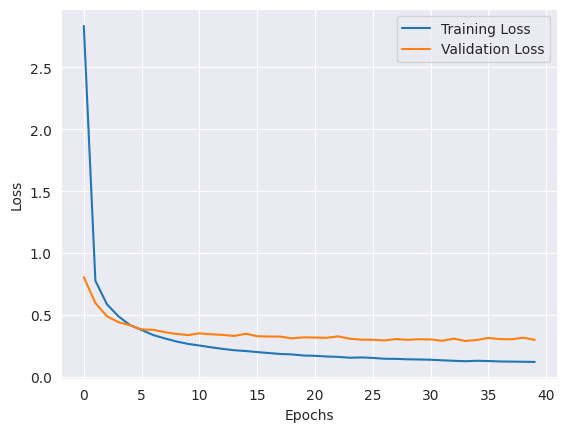

In [25]:
# Training and Validation Loss Curve
import matplotlib.pyplot as plt

# history = model.fit(train_gen, validation_data=valid_gen, epochs=40)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


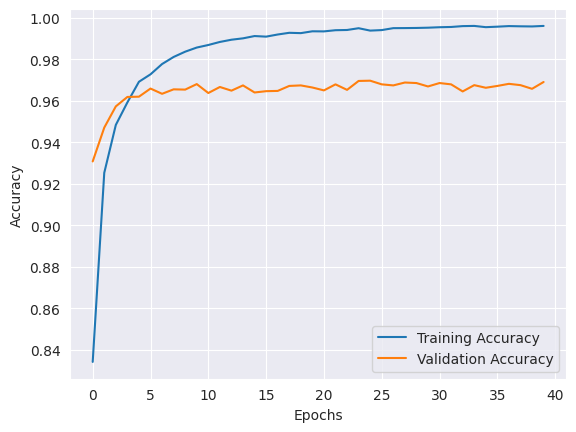

In [26]:
#Training and Validation Accuracy Curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


719/719 [==============================] - 183s 249ms/step


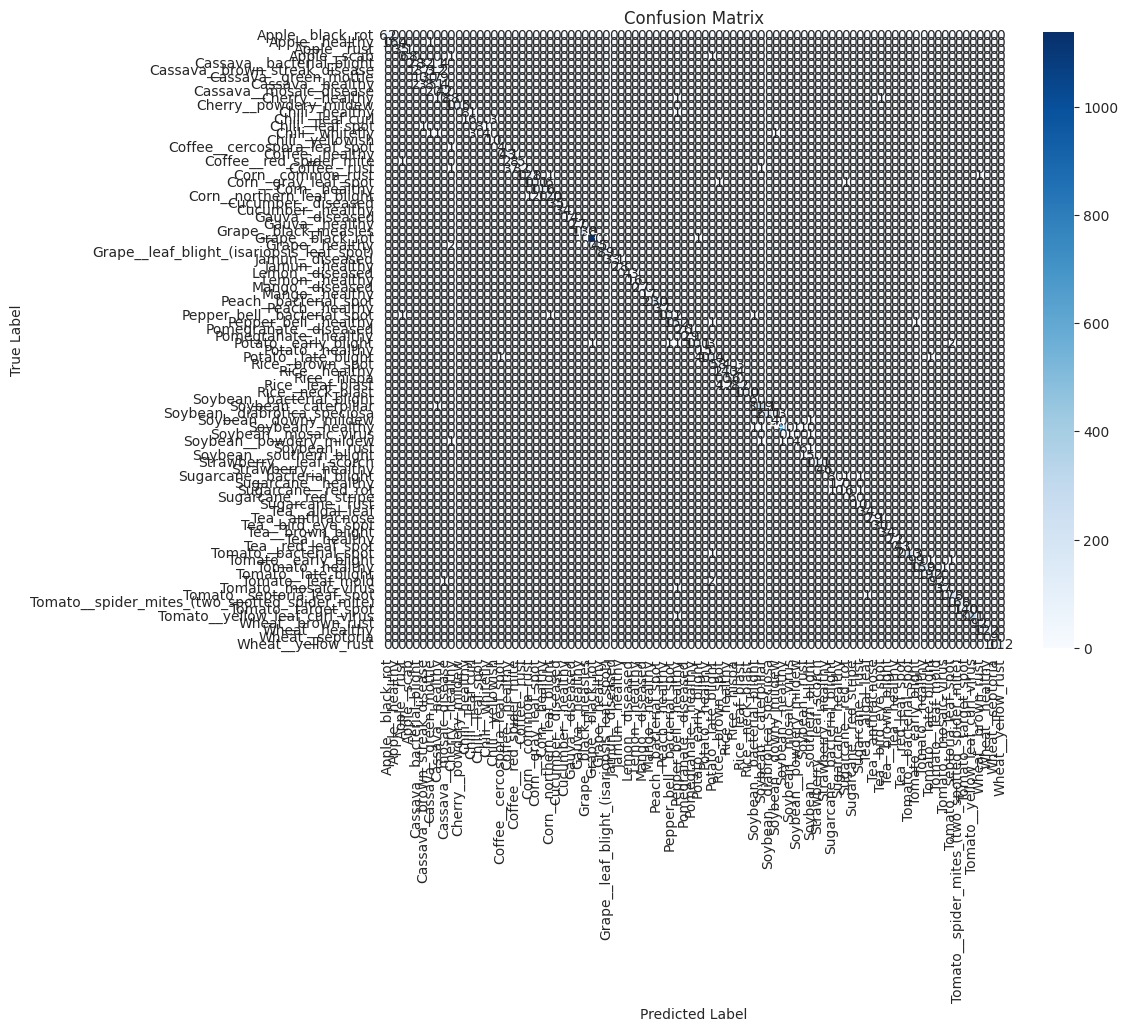

In [27]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_gen.classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


719/719 [==============================] - 89s 123ms/step


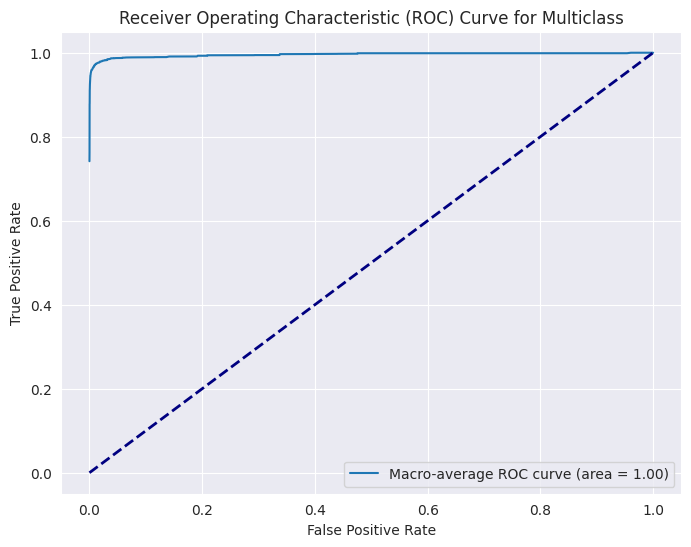

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_pred is the predicted probabilities for each class
# Assuming test_gen is your test data generator

# Predict probabilities for the test data
y_pred_proba = model.predict(test_gen)

# Binarize the true labels
y_true = label_binarize(test_gen.classes, classes=range(88))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(88):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(88)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(88):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 88
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot micro-average and macro-average ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_macro, tpr_macro, label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_macro))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc="lower right")
plt.show()


In [36]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing import image

# # Assuming 'model' is your Keras Sequential model
# # Assuming 'images_per_row' is defined

# # Extract features from intermediate layers
# layer_outputs = [layer.output for layer in model.layers[1:]]
# activation_model = Model(inputs=model.input, outputs=layer_outputs)

# # Load an example image for visualization
# img_path = '/kaggle/input/plant-disease-classification-merged-dataset/Soybean__mosaic_virus/DSC_0133.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# # x = preprocess_input(x)  # Preprocess the image if needed
# activations = activation_model.predict(x)

# # Visualize feature maps
# layer_names = [layer.name for layer in model.layers[1:]]
# for layer_name, layer_activation in zip(layer_names, activations):
#     if len(layer_activation.shape) == 4:
#         n_features = layer_activation.shape[-1]  # Number of features in the feature map
#         size = layer_activation.shape[1]  # The feature map has shape (1, size, size, n_features).
#         n_cols = n_features // images_per_row
#         display_grid = np.zeros((size * n_cols, images_per_row * size))
#         for col in range(n_cols):  # Tiles each filter into a big horizontal grid
#             for row in range(images_per_row):
#                 if col * images_per_row + row < n_features:  # Check if index is within bounds
#                     channel_image = layer_activation[0, :, :, col * images_per_row + row]
#                     channel_image -= channel_image.mean()  # Post-processes the feature to make it visually palatable
#                     channel_image /= channel_image.std()
#                     channel_image *= 64
#                     channel_image += 128
#                     channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#                     display_grid[col * size : (col + 1) * size,
#                                  row * size : (row + 1) * size] = channel_image
#         scale = 1. / size
#         plt.figure(figsize=(scale * display_grid.shape[1],
#                             scale * display_grid.shape[0]))
#         plt.title(layer_name)
#         plt.grid(False)
#         plt.imshow(display_grid, aspect='auto', cmap='viridis')


1/1 [==============================] - 3s 3s/step


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Assuming 'model' is your Keras Sequential model
# Assuming 'images_per_row' is defined

# Extract features from intermediate layers
layer_outputs = [layer.output for layer in model.layers[1:]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Load an example image for visualization
img_path = '/kaggle/input/plant-disease-classification-merged-dataset/Soybean__mosaic_virus/DSC_0133.jpg'
print("Image Path:", img_path)
img = image.load_img(img_path, target_size=(224, 224))
if img is None:
    print("Failed to load the image.")
else:
    print("Image loaded successfully.")

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)  # Preprocess the image if needed
activations = activation_model.predict(x)

# Visualize feature maps
layer_names = [layer.name for layer in model.layers[1:]]
for layer_name, layer_activation in zip(layer_names, activations):
    if len(layer_activation.shape) == 4:
        n_features = layer_activation.shape[-1]  # Number of features in the feature map
        size = layer_activation.shape[1]  # The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):  # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                if col * images_per_row + row < n_features:  # Check if index is within bounds
                    channel_image = layer_activation[0, :, :, col * images_per_row + row]
                    channel_image -= channel_image.mean()  # Post-processes the feature to make it visually palatable
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size,
                                 row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')



Image Path: /kaggle/input/plant-disease-classification-merged-dataset/Soybean__mosaic_virus/DSC_0133.jpg
Image loaded successfully.
1/1 [==============================] - 3s 3s/step
